In [2]:
# Change Python path
import os, sys
os.chdir("/LOCALDATA/ARTHURs_FILES/Codigos/")
print(os.getcwd())
sys.path.append('python_modules')

# Enables modules autoreload (important during development)
%load_ext autoreload
%autoreload 2

/LOCALDATA/ARTHURs_FILES/Codigos


In [ ]:
from data_managers.load_save_cmems_sst import load_cmems_sst

# Loading Dataset
ds_cmems_sst = load_cmems_sst(
    # years=range(2009, 2014),
    # lon_selector=slice(2, 2.10),
    # lat_selector=slice(39, 39.1)
    region_selector="balears"
)

# Chunking, default is to auto
ds_cmems_sst = ds_cmems_sst.chunk({"lat": "auto", "lon": "auto", "time": -1})

ds_cmems_sst

Loaded CMEMS-SST dataset.


<xarray.Dataset> Size: 508MB
Dimensions:  (time: 15340, lat: 69, lon: 120)
Coordinates:
  * lat      (lat) float32 276B 37.65 37.7 37.75 37.8 ... 40.96 41.01 41.06
  * lon      (lon) float32 480B -0.8591 -0.8091 -0.7591 ... 4.996 5.046 5.096
  * time     (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
Data variables:
    T        (time, lat, lon) float32 508MB dask.array<chunksize=(15340, 35, 61), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                CF-1.4 
    title:                      Mediterranean Sea SST Analysis L4, Reprocesse...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    references:                 A. Pisano, B. Buongiorno Nardelli, C. Troncon...
    institution:                GOS
    history:                    Mon Jun 10 12:26:11 2024: ncrcat 198201010000...
    ...                         ...
    publisher_name:             CNR ISMAR GOS - CMEMS SST-TAC
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@isa...
    processing_level:           L4
    cdm_data_type:              grid
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...

In [ ]:
from data_managers.process_data import calculate_climatology
from data_managers.load_save_cmems_sst import save_cmems_sst_clim

ds_clim = calculate_climatology(ds_cmems_sst)

save_cmems_sst_clim(
    ds_clim, 
    clim_year_start = int(ds_cmems_sst["time.year"].min().values),
    clim_year_end   = int(ds_cmems_sst["time.year"].max().values),
    region="balears"
)

ds_clim

Saving CMEMS-SST climatology dataset to /LOCALDATA/ARTHURs_FILES/Codigos/../Datos/CMEMS-SST/processed/cmems_sst_clim_balears_1982_2023.nc
[########################################] | 100% Completed | 48.92 s
 -> Saved!


<xarray.Dataset> Size: 12MB
Dimensions:    (dayofyear: 366, lat: 69, lon: 120)
Coordinates:
  * lat        (lat) float32 276B 37.65 37.7 37.75 37.8 ... 40.96 41.01 41.06
  * lon        (lon) float32 480B -0.8591 -0.8091 -0.7591 ... 4.996 5.046 5.096
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    T          (dayofyear, lat, lon) float32 12MB dask.array<chunksize=(1, 35, 61), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                CF-1.4 
    title:                      Mediterranean Sea SST Analysis L4, Reprocesse...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    references:                 A. Pisano, B. Buongiorno Nardelli, C. Troncon...
    institution:                GOS
    history:                    Mon Jun 10 12:26:11 2024: ncrcat 198201010000...
    ...                         ...
    publisher_name:             CNR ISMAR GOS - CMEMS SST-TAC
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@isa...
    processing_level:           L4
    cdm_data_type:              grid
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...

In [ ]:
from data_managers.load_save_cmems_sst import load_cmems_sst_clim

ds_clim = load_cmems_sst_clim(
    clim_year_start = int(ds_cmems_sst["time.year"].min().values),
    clim_year_end   = int(ds_cmems_sst["time.year"].max().values),
    region="balears"
)

Loaded CMEMS-SST climatology.


In [5]:
# Assume ds and clim are your datasets
# ds.T: (time, lat, lon)
# clim.T: (dayofyear, lat, lon)

# 1. Add 'dayofyear' coordinate to ds based on 'time'
ds_cmems_sst_doy = ds_cmems_sst.assign_coords(dayofyear = ds_cmems_sst['time.dayofyear'])

# 3. Groupby dayofyear and subtract climatology
ds_ssta = ds_cmems_sst_doy.groupby('dayofyear') - ds_clim
ds_ssta

<xarray.Dataset> Size: 508MB
Dimensions:    (lat: 69, lon: 120, time: 15340)
Coordinates:
  * lat        (lat) float32 276B 37.65 37.7 37.75 37.8 ... 40.96 41.01 41.06
  * lon        (lon) float32 480B -0.8591 -0.8091 -0.7591 ... 4.996 5.046 5.096
  * time       (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
Data variables:
    T          (time, lat, lon) float32 508MB dask.array<chunksize=(1, 35, 61), meta=np.ndarray>

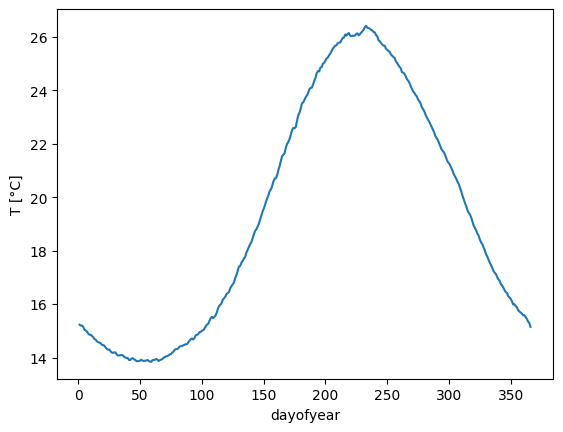

In [16]:
ds_mean = ds_clim.mean(dim=["lon","lat"], keep_attrs=True)
ds_mean.T.plot()

In [20]:
ds_mean

<xarray.Dataset> Size: 4kB
Dimensions:    (dayofyear: 366)
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    T          (dayofyear) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                CF-1.4 
    title:                      Mediterranean Sea SST Analysis L4, Reprocesse...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    references:                 A. Pisano, B. Buongiorno Nardelli, C. Troncon...
    institution:                GOS
    history:                    Mon Jun 10 12:26:11 2024: ncrcat 198201010000...
    ...                         ...
    publisher_name:             CNR ISMAR GOS - CMEMS SST-TAC
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@isa...
    processing_level:           L4
    cdm_data_type:              grid
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...

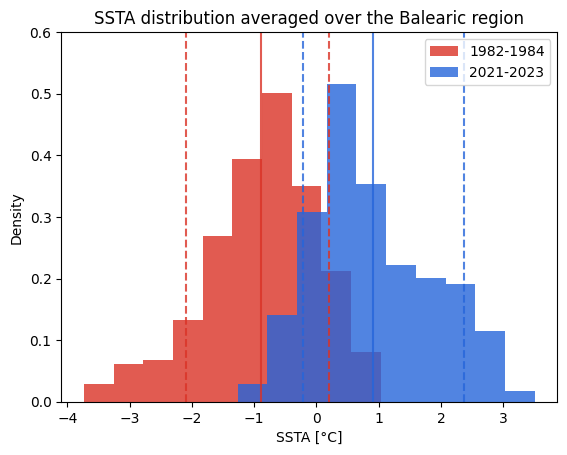

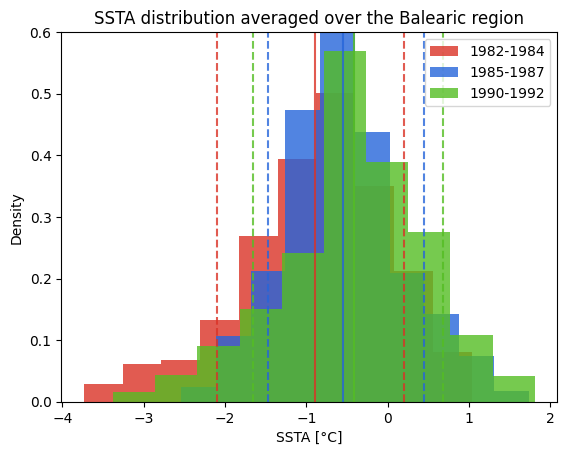

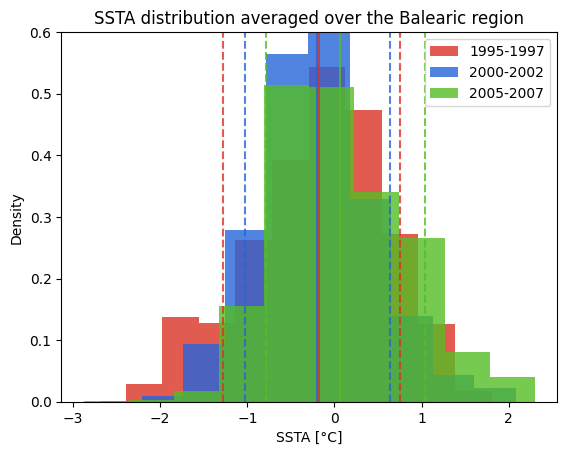

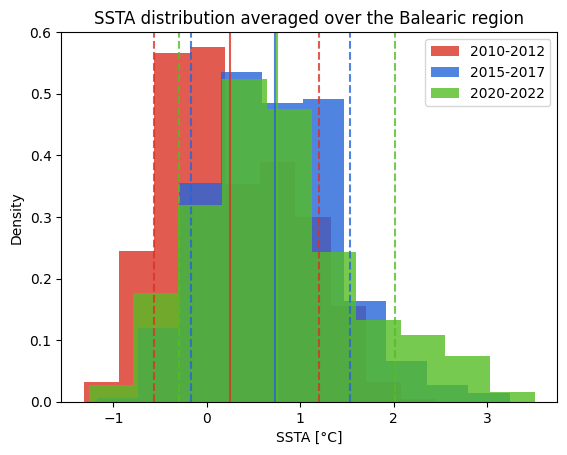

In [6]:
import matplotlib.pyplot as plt

# das = [
#     ds_ssta.sel(time=slice(f"1982-01-01", f"1984-12-31")).T.mean(dim=["lon","lat"], keep_attrs=True).compute(),
#     ds_ssta.sel(time=slice(f"2021-01-01", f"2023-12-31")).T.mean(dim=["lon","lat"], keep_attrs=True).compute()
# ]

for years in [
    [1982, 2021],
    [1982, 1985, 1990],
    [1995, 2000, 2005],
    [2010, 2015, 2020]
]:
    for i, year in enumerate(years):
        # da = das[i]
        da = ds_ssta.sel(time=slice(f"{year}-01-01", f"{year+2}-12-31")).T
        da = da.mean(dim=["lon","lat"], keep_attrs=True).compute()
        color = ["#DA3226CC", "#2665DACC", "#54BD23CC", "#A926D1CC"][i]
        
        plt.hist(da, 10, density=True, label=f"{year}-{year+2}", alpha=0.8, color=color)

        plt.vlines(da.quantile(0.1).values, ymin=0, ymax=1, linestyles="--", color=color)
        plt.vlines(da.mean().values, ymin=0, ymax=1, color=color)
        plt.vlines(da.quantile(0.9).values, ymin=0, ymax=1, linestyles="--", color=color)

    plt.ylim(0, 0.6)
    plt.ylabel("Density")
    plt.xlabel("SSTA [°C]")
    plt.title("SSTA distribution averaged over the Balearic region")

    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_distrib(ds_ssta, year_ranges):
    for i, (year_start, year_end) in enumerate(year_ranges):
        # da = das[i]
        da = ds_ssta.sel(time=slice(f"{year}-01-01", f"{year+2}-12-31")).T
        da = da.mean(dim=["lon","lat"], keep_attrs=True).compute()
        color = ["#DA3226CC", "#2665DACC", "#54BD23CC", "#A926D1CC"][i]
        
        plt.hist(da, 10, density=True, label=f"{year}-{year+2}", alpha=0.8, color=color)

        plt.vlines(da.quantile(0.1).values, ymin=0, ymax=1, linestyles="--", color=color)
        plt.vlines(da.median().values, ymin=0, ymax=1, color=color)
        plt.vlines(da.quantile(0.9).values, ymin=0, ymax=1, linestyles="--", color=color)

    plt.ylim(0, 0.6)
    plt.ylabel("Density")
    plt.xlabel("SSTA [°C]")
    plt.title("SSTA distribution averaged over the Balearic region")

    plt.legend()
    plt.show()

In [ ]:
from data_plotters.basic_plotting import subplot

nb_years = 3

subplot(
    (2, 2),
    [
        dict(
            pos = i,
            func = plot_distrib,
            ds_ssta = ds_cmems_sst,
            year_range = range(year, year+nb_years)
        )
    ]
)